In [ ]:
# Experiment 8

In [28]:
import matplotlib.animation as ani
import matplotlib.cm as cmx
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import random
import imageio
from matplotlib.patches import Ellipse
from PIL import Image
from sklearn import datasets
from sklearn.cluster import KMeans

In [16]:
def generate_points(n = 20):
    # generate random x,y coordinates
    points = []
    while len(points)<n:
        X = random.randint(-n,n)
        Y = random.randint(-n,n)
        if [X,Y] not in points:
            points.append([X,Y])
    return np.asarray(points)

In [17]:
def gaussian(X, mu, cov):
    # return gaussian distribution
    n = X.shape[1]
    diff = (X - mu).T
    return np.diagonal(1 / ((2 * np.pi) ** (n / 2) * np.linalg.det(cov) ** 0.5) * np.exp(-0.5 * np.dot(np.dot(diff.T, np.linalg.inv(cov)), diff))).reshape(-1, 1)

In [18]:
def initialize_clusters(X, n_clusters):
    # We use the KMeans centroids to initialise the GMM
    clusters = []
    idx = np.arange(X.shape[0])
    
    kmeans = KMeans(n_clusters).fit(X)
    mu_k = kmeans.cluster_centers_
    
    for i in range(n_clusters):
        clusters.append({
            'pi_k': 1.0 / n_clusters,
            'mu_k': mu_k[i],
            'cov_k': np.identity(X.shape[1], dtype=np.float64)
        })
        
    return clusters

In [19]:
def expectation_step(X, clusters):
    totals = np.zeros((X.shape[0], 1), dtype=np.float64)
    
    for cluster in clusters:
        pi_k = cluster['pi_k']
        mu_k = cluster['mu_k']
        cov_k = cluster['cov_k']
        
        gamma_nk = (pi_k * gaussian(X, mu_k, cov_k)).astype(np.float64)
        
        for i in range(X.shape[0]):
            totals[i] += gamma_nk[i]
        
        cluster['gamma_nk'] = gamma_nk
        cluster['totals'] = totals
        
    
    for cluster in clusters:
        cluster['gamma_nk'] /= cluster['totals']

In [20]:
def maximization_step(X, clusters):
    N = float(X.shape[0])
  
    for cluster in clusters:
        gamma_nk = cluster['gamma_nk']
        cov_k = np.zeros((X.shape[1], X.shape[1]))
        
        N_k = np.sum(gamma_nk, axis=0)
        
        pi_k = N_k / N
        mu_k = np.sum(gamma_nk * X, axis=0) / N_k
        
        for j in range(X.shape[0]):
            diff = (X[j] - mu_k).reshape(-1, 1)
            cov_k += gamma_nk[j] * np.dot(diff, diff.T)
            
        cov_k /= N_k
        
        cluster['pi_k'] = pi_k
        cluster['mu_k'] = mu_k
        cluster['cov_k'] = cov_k

In [21]:
def get_likelihood(X, clusters):
    sample_likelihoods = np.log(np.array([cluster['totals'] for cluster in clusters]))
    return np.sum(sample_likelihoods), sample_likelihoods

In [22]:
def train_gmm(X, n_clusters, n_epochs):
    clusters = initialize_clusters(X, n_clusters)
    likelihoods = np.zeros((n_epochs, ))
    scores = np.zeros((X.shape[0], n_clusters))
    history = []

    for i in range(n_epochs):
        clusters_snapshot = []
        
        for cluster in clusters:
            clusters_snapshot.append({
                'mu_k': cluster['mu_k'].copy(),
                'cov_k': cluster['cov_k'].copy()
            })
            
        history.append(clusters_snapshot)
      
        expectation_step(X, clusters)
        maximization_step(X, clusters)

        likelihood, sample_likelihoods = get_likelihood(X, clusters)
        likelihoods[i] = likelihood

        print('Epoch: ', i + 1, 'Likelihood: ', likelihood)
        
    for i, cluster in enumerate(clusters):
        scores[:, i] = np.log(cluster['gamma_nk']).reshape(-1)
        
    return clusters, likelihoods, scores, sample_likelihoods, history

In [ ]:
# now we execute all methods sequentially

In [42]:
# get dataset
X = generate_points(40)

In [43]:
# run the mixture of gaussians model
n_clusters = 3
n_epochs = 50

clusters, likelihoods, scores, sample_likelihoods, history = train_gmm(X, n_clusters, n_epochs)

Epoch:  1 Likelihood:  -17638.517683648253
Epoch:  2 Likelihood:  -1045.9663638913894
Epoch:  3 Likelihood:  -1045.1725982771347
Epoch:  4 Likelihood:  -1045.0724965702332
Epoch:  5 Likelihood:  -1045.0350572614611
Epoch:  6 Likelihood:  -1045.00836687243
Epoch:  7 Likelihood:  -1044.9845122080087
Epoch:  8 Likelihood:  -1044.9615735313323
Epoch:  9 Likelihood:  -1044.9389129869267
Epoch:  10 Likelihood:  -1044.9162881662896
Epoch:  11 Likelihood:  -1044.8936095142558
Epoch:  12 Likelihood:  -1044.8708542222207
Epoch:  13 Likelihood:  -1044.8480312409465
Epoch:  14 Likelihood:  -1044.8251662979733
Epoch:  15 Likelihood:  -1044.8022955776423
Epoch:  16 Likelihood:  -1044.7794634033
Epoch:  17 Likelihood:  -1044.7567218562745
Epoch:  18 Likelihood:  -1044.734131341757
Epoch:  19 Likelihood:  -1044.7117615606005
Epoch:  20 Likelihood:  -1044.6896925209708
Epoch:  21 Likelihood:  -1044.6680152769104
Epoch:  22 Likelihood:  -1044.6468320852491
Epoch:  23 Likelihood:  -1044.6262556696556
Epo

<ipython-input-17-d2d3955f96dc>:4: RuntimeWarning: overflow encountered in exp
  return np.diagonal(1 / ((2 * np.pi) ** (n / 2) * np.linalg.det(cov) ** 0.5) * np.exp(-0.5 * np.dot(np.dot(diff.T, np.linalg.inv(cov)), diff))).reshape(-1, 1)


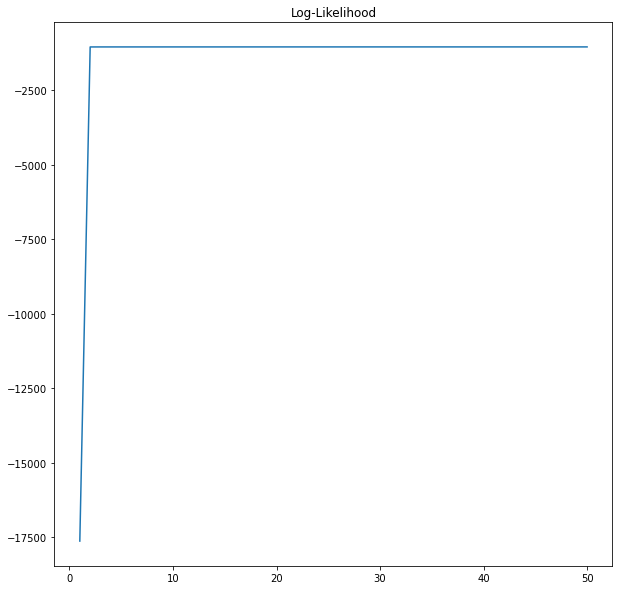

In [44]:
# plot log likelihood
plt.figure(figsize=(10, 10))
plt.title('Log-Likelihood')
plt.plot(np.arange(1, n_epochs + 1), likelihoods)
plt.show()

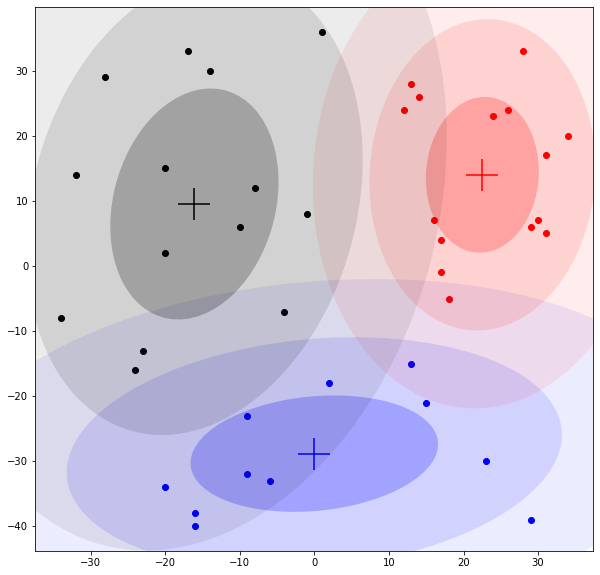

In [45]:
# create clustering plot
def create_cluster_animation(X, history, scores):
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    colorset = ['blue', 'red', 'black']
    images = []
    
    for j, clusters in enumerate(history):
      
        idx = 0
      
        if j % 3 != 0:
            continue
        
        plt.cla()
        
        for cluster in clusters:
            mu = cluster['mu_k']
            cov = cluster['cov_k']

            eigenvalues, eigenvectors = np.linalg.eigh(cov)
            order = eigenvalues.argsort()[::-1]
            eigenvalues, eigenvectors = eigenvalues[order], eigenvectors[:, order]
            vx, vy = eigenvectors[:,0][0], eigenvectors[:,0][1]
            theta = np.arctan2(vy, vx)

            color = colors.to_rgba(colorset[idx])

            for cov_factor in range(1, 4):
                ell = Ellipse(xy=mu, width=np.sqrt(eigenvalues[0]) * cov_factor * 2, height=np.sqrt(eigenvalues[1]) * cov_factor * 2, angle=np.degrees(theta), linewidth=2)
                ell.set_facecolor((color[0], color[1], color[2], 1.0 / (cov_factor * 4.5)))
                ax.add_artist(ell)

            ax.scatter(cluster['mu_k'][0], cluster['mu_k'][1], c=colorset[idx], s=1000, marker='+')
            idx += 1

        for i in range(X.shape[0]):
            ax.scatter(X[i, 0], X[i, 1], c=colorset[np.argmax(scores[i])], marker='o')
        
        fig.canvas.draw()
        
        image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

        images.append(image)
    
    kwargs_write = {'fps':1.0, 'quantizer':'nq'}
    imageio.mimsave('./gmm.gif', images, fps=1)
    plt.show(Image.open('gmm.gif').convert('RGB'))
    
    
create_cluster_animation(X, history, scores)